# 0.0. PREPARATION

## 0.1. Assumptions

**Variables**

RowNumber -> number of the row.<br>
CustomerId -> unique value to indentify each customer.<br>
Surname -> customer's last name.<br>
CreditScore -> three-digit number that rates the customers creditworthiness from 300 to 850.<br>
Geography -> customer's country.<br>
Gender -> customer's gender.<br>
Age -> customer's age.<br>
Tenure -> time in months since customers joined the customer base.<br>
Balance -> amount of money spent by the customer.<br>
NumOfProducts -> quantity of products purchased by the customer.<br>
HasCrCard -> 1 if customer has credit card, 0 if not.<br>
IsActiveMember -> 1 if custmer is active, 0 if not.<br>
EstimatedSalary -> predicted salary of the customer.

## 0.2. Imports

In [145]:
import json
import pickle
import requests

import numpy             as np
import pandas            as pd
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt

from sklearn  import metrics         as mt
from sklearn  import ensemble        as en
from sklearn  import neighbors       as nh
from sklearn  import linear_model    as lm
from sklearn  import preprocessing   as pp
from sklearn  import model_selection as ms
from imblearn import combine         as cb

from scipy                     import stats
from xgboost                   import XGBClassifier
from ydata_profiling           import ProfileReport
from IPython.core.display      import HTML
from sklearn.feature_selection import SelectFromModel

## 0.3. Load Data

In [146]:
df_raw = pd.read_csv('../data/abandono_clientes.csv')

### 0.3.1. Split Test Data

In [147]:
df1, df_test = ms.train_test_split(df_raw, test_size=0.15)

## 0.4. Helper Functions

In [148]:
# this function calculates Cramer V measure with bias correction
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

# this function apply cramer_v() function to each feature and store in dictionary
def corr_cramer_v(cat_attributes):
    cat_attributes_list = cat_attributes.columns.tolist()
    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

# this function allows me to apply cross validation using StratifiedKFold e calculate precision, recall and f1_score
def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict(x_val_fold)
        
        #x_val_fold['response'] = y_val_fold
        
        precision = mt.precision_score(y_val_fold, yhat_model)
        recall = mt.recall_score(y_val_fold, yhat_model)
        f1_score = mt.f1_score(y_val_fold, yhat_model, average='macro')
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    f1_score_str = np.round(np.mean(f1_score_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_score_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)
    
    return models_performance

# this function sets prefencial jupyter notebook parameters
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [149]:
jupyter_settings()

# 1.0. DATA DESCRIPTION

In [150]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8943,8944,15727350,Pai,516,France,Female,37,8,113143.12,1,0,0,3363.36,0
9630,9631,15801462,Yermakov,716,France,Male,31,8,109578.04,2,1,1,51503.51,0
4520,4521,15605826,Korovina,652,Germany,Male,46,10,121063.80,3,1,0,151481.86,1
9932,9933,15813451,Fleetwood-Smith,677,Spain,Male,18,8,134796.87,2,1,1,114858.90,0
1157,1158,15811327,Pan,700,Spain,Male,54,1,79415.67,1,0,1,139735.54,0


## 1.1. Data Dimensions

In [151]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8500
Number of columns: 14


## 1.2. Data Types

In [152]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.3. Checks

In [153]:
# check na
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [154]:
# check duplicates
df1.duplicated().sum()

0

In [155]:
# check balance
df1['Exited'].value_counts(normalize=True)

0    0.796471
1    0.203529
Name: Exited, dtype: float64

## 1.4. Descriptive Analysis

In [156]:
num_attributes = df1[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
cat_attributes = df1[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

### 1.4.1. Numerical Attributes

In [157]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat metrics
num_statics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_statics.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [158]:
num_statics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,CreditScore,350.00,850.00,500.00,650.929294,652.00,96.680015,-0.078944,-0.427758
1,Age,18.00,92.00,74.00,38.952235,37.00,10.477250,0.993510,1.353719
2,Tenure,0.00,10.00,10.00,5.009059,5.00,2.895276,0.016380,-1.165434
3,Balance,0.00,250898.09,250898.09,76522.742966,97173.29,62454.694490,-0.137918,-1.486066
4,NumOfProducts,1.00,4.00,3.00,1.528353,1.00,0.581091,0.742368,0.543275
5,EstimatedSalary,11.58,199992.48,199980.90,99795.960192,99803.43,57529.138486,0.006916,-1.183130


### 1.4.2. Categorical Attributes

In [159]:
cat_attributes.apply(lambda x: x.unique().shape[0])

Geography         3
Gender            2
HasCrCard         2
IsActiveMember    2
Exited            2
dtype: int64

### 1.4.3. Pandas Profiling

In [160]:
# prof = ProfileReport(df1)
# prof.to_file(output_file='../reports/output.html')

**Notes From Pandas Profiling Report**

* Maximum value of CreditScore (850) is the most common.
* Column Age could be similar to normal distribution.
* Tenure has low variance.
* Lot of zeroes in Balance (36%).
* Some very low values in EstimatedSalary.
* Imbalanced problem (80/20)

# 2.0. FEATURE ENGINEERING

In [161]:
df2 = df1#.copy()

In [162]:
# average ticket
df2['AvgTicket'] = [np.round(x['Balance'] / x['NumOfProducts'], 2) if x['NumOfProducts'] != 0 else 0 for _, x in df2.iterrows()]

# 3.0. DATA FILTERING

In [163]:
df3 = df2#.copy()

In [164]:
# no outliers found. Unused columns will be removed at data preparation,

# 4.0. EXPLORATORY DATA ANALYSIS

In [165]:
df4 = df3#.copy()

## 4.1. Univariate Analysis

In [166]:
num_attributes = df4[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'AvgTicket']]
cat_attributes = df4[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

### 4.1.1. Response Variable

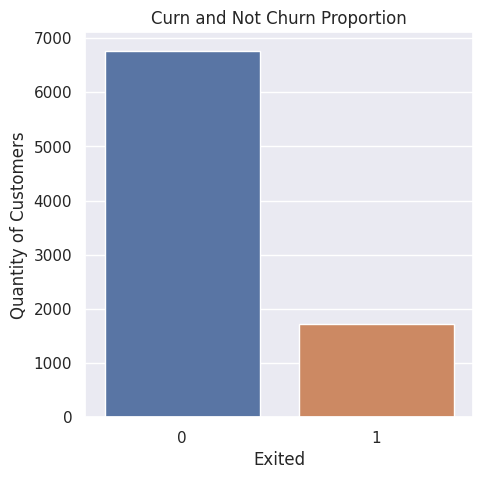

In [167]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='Exited', data=df4);
plt.ylabel('Quantity of Customers');
plt.title('Curn and Not Churn Proportion');

### 4.1.2. Numerical Variables

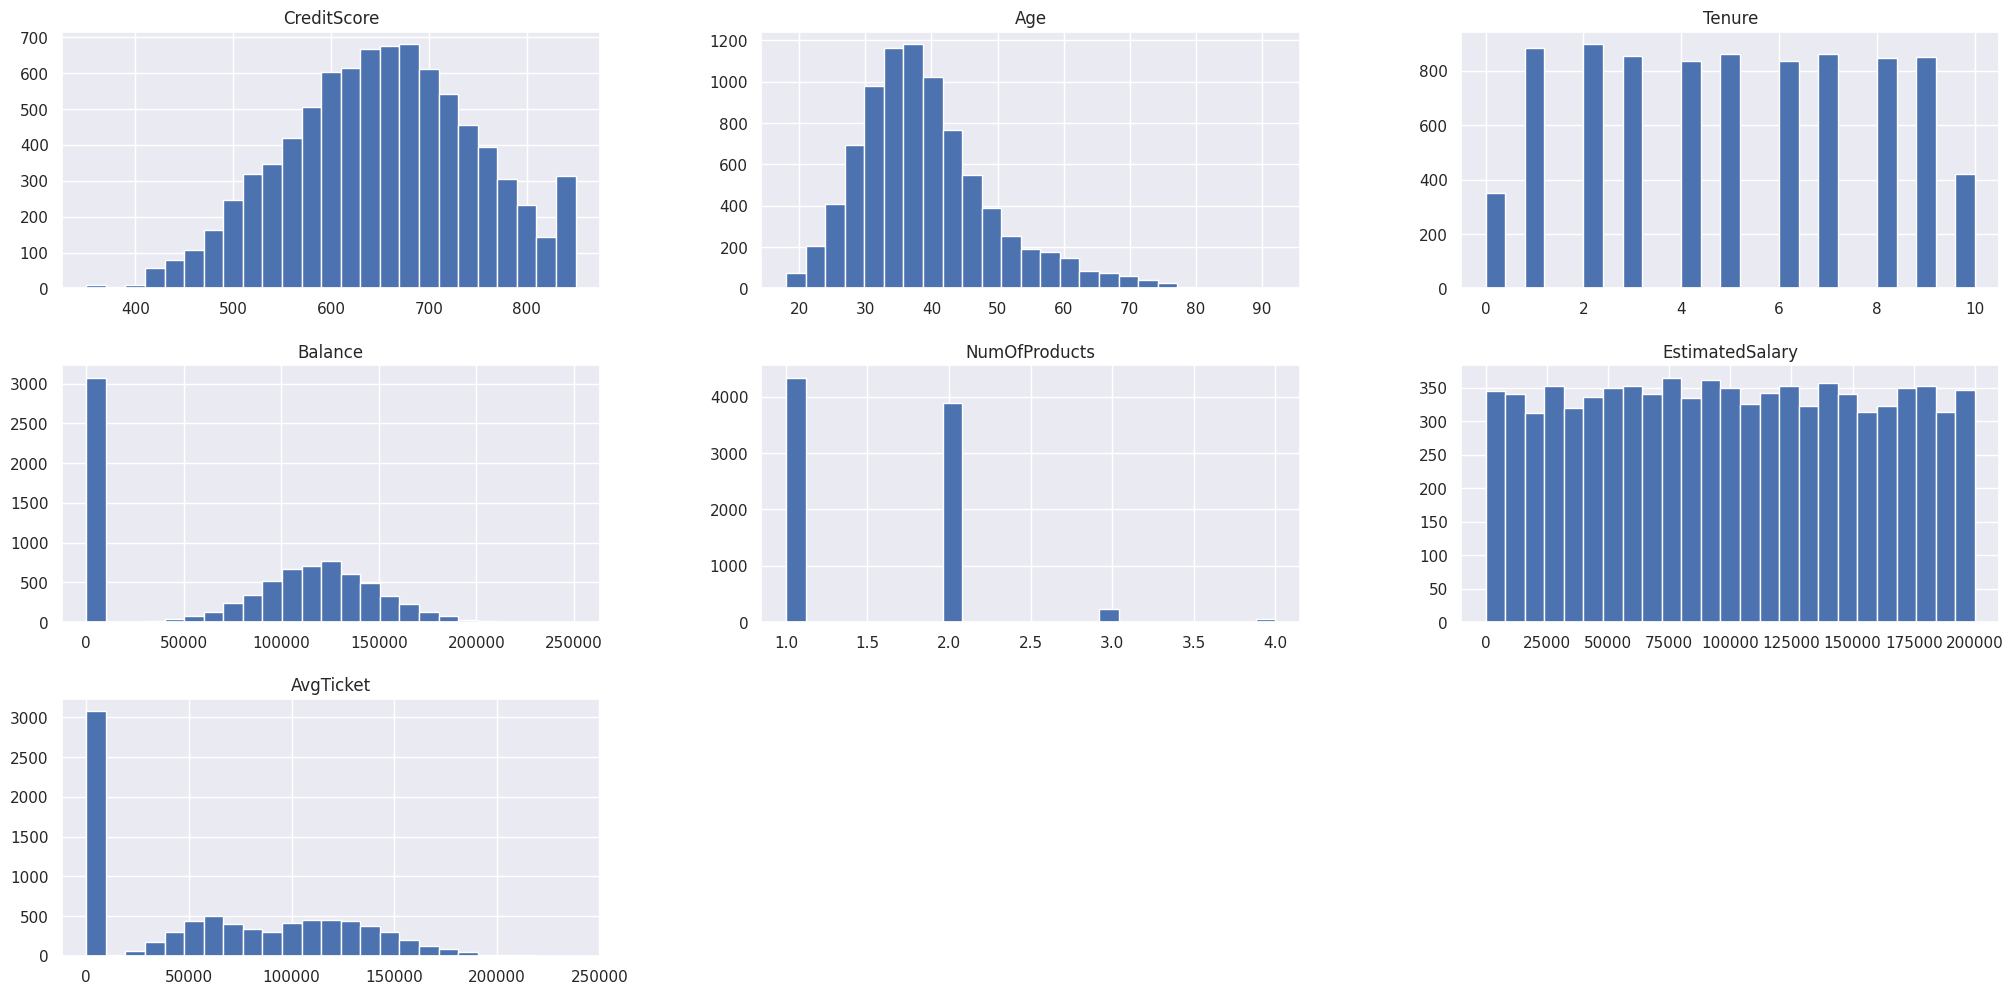

In [168]:
num_attributes.hist(bins=25);

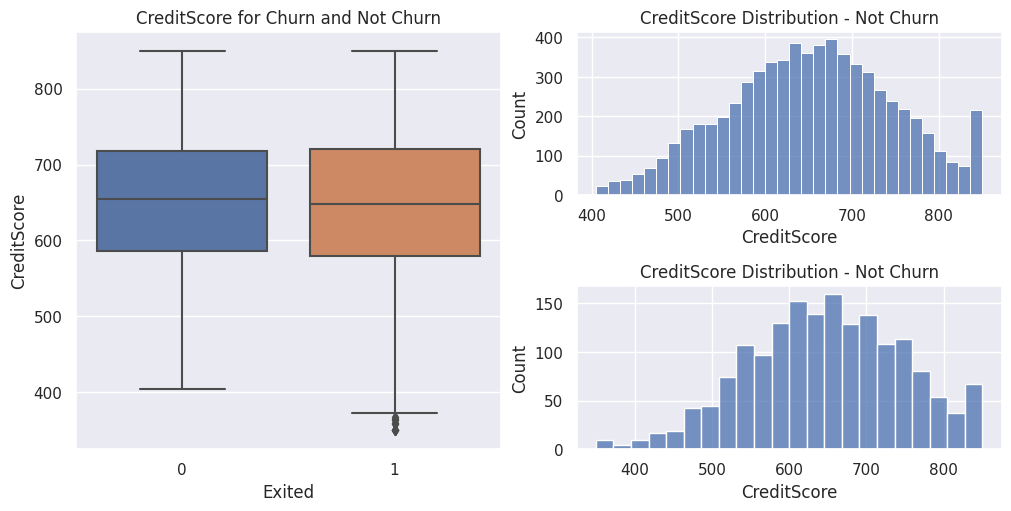

In [169]:
# Credit Score
axd = plt.figure(figsize=(10,5), constrained_layout=True).subplot_mosaic("""AB
                                                                            AC""")

axd['A'].set_title('CreditScore for Churn and Not Churn')
sns.boxplot(ax=axd['A'], x='Exited', y='CreditScore', data=df4);

axd['B'].set_title('CreditScore Distribution - Not Churn')
CreditScore0 = df4.loc[df4['Exited'] == 0, 'CreditScore']
sns.histplot(ax=axd['B'], data=CreditScore0);

axd['C'].set_title('CreditScore Distribution - Not Churn')
CreditScore1 = df4.loc[df4['Exited'] == 1, 'CreditScore']
sns.histplot(ax = axd['C'], data=CreditScore1);

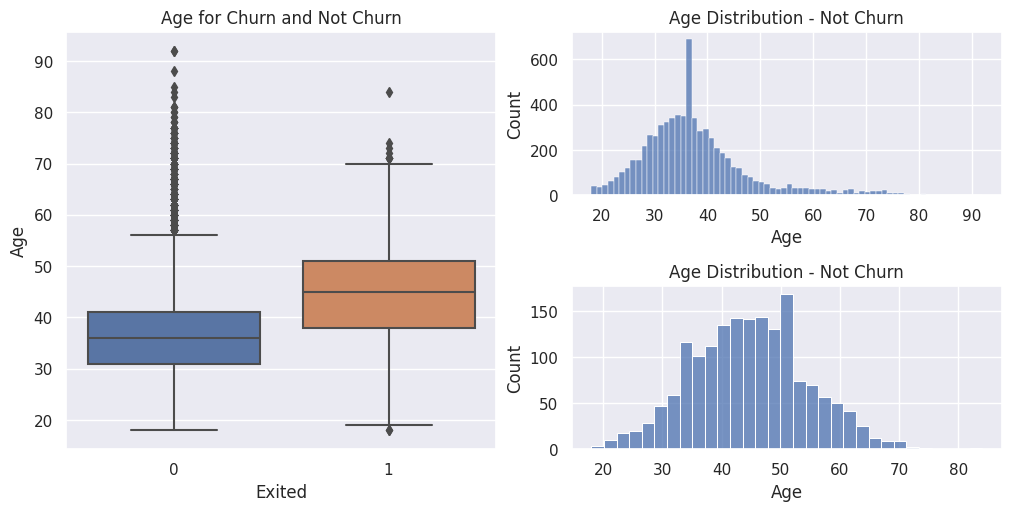

In [170]:
# Age
axd = plt.figure(figsize=(10,5), constrained_layout=True).subplot_mosaic("""AB
                                                                            AC""")

axd['A'].set_title('Age for Churn and Not Churn')
sns.boxplot(ax=axd['A'], x='Exited', y='Age', data=df4);

axd['B'].set_title('Age Distribution - Not Churn')
Age0 = df4.loc[df4['Exited'] == 0, 'Age']
sns.histplot(ax=axd['B'], data=Age0);

axd['C'].set_title('Age Distribution - Not Churn')
Age1 = df4.loc[df4['Exited'] == 1, 'Age']
sns.histplot(ax = axd['C'], data=Age1);

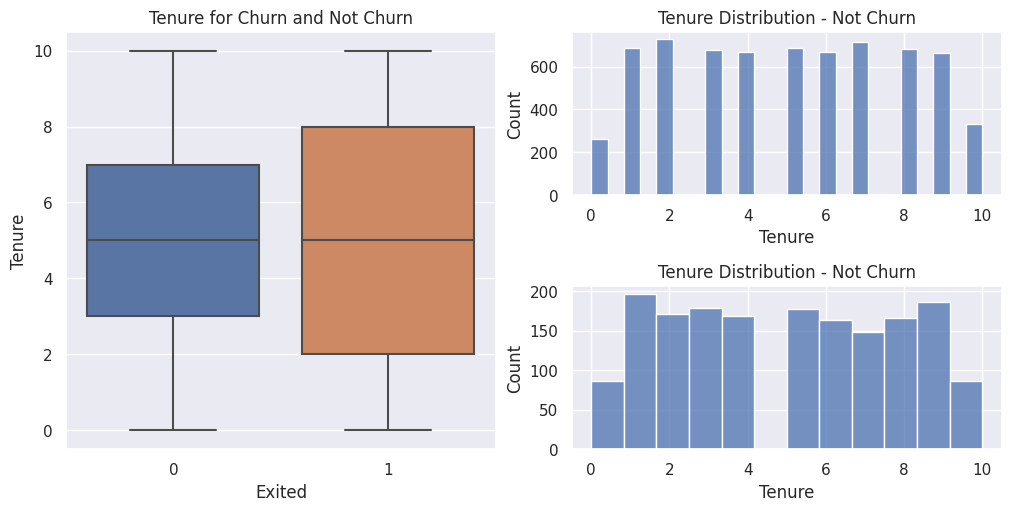

In [171]:
# Tenure
axd = plt.figure(figsize=(10,5), constrained_layout=True).subplot_mosaic("""AB
                                                                            AC""")

axd['A'].set_title('Tenure for Churn and Not Churn')
sns.boxplot(ax=axd['A'], x='Exited', y='Tenure', data=df4);

axd['B'].set_title('Tenure Distribution - Not Churn')
Tenure0 = df4.loc[df4['Exited'] == 0, 'Tenure']
sns.histplot(ax=axd['B'], data=Tenure0);

axd['C'].set_title('Tenure Distribution - Not Churn')
Tenure1 = df4.loc[df4['Exited'] == 1, 'Tenure']
sns.histplot(ax = axd['C'], data=Tenure1);

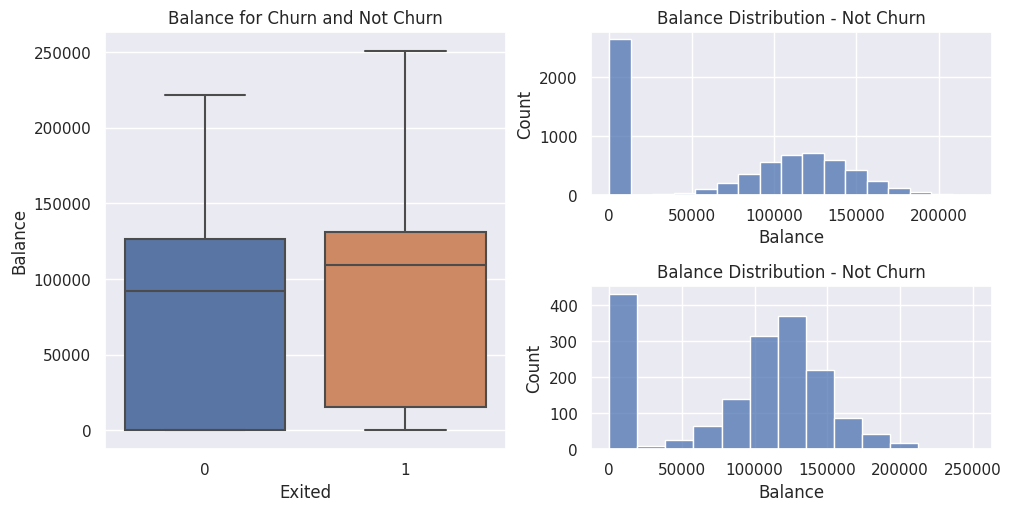

In [172]:
# Balance
axd = plt.figure(figsize=(10,5), constrained_layout=True).subplot_mosaic("""AB
                                                                            AC""")

axd['A'].set_title('Balance for Churn and Not Churn')
sns.boxplot(ax=axd['A'], x='Exited', y='Balance', data=df4);

axd['B'].set_title('Balance Distribution - Not Churn')
Balance0 = df4.loc[df4['Exited'] == 0, 'Balance']
sns.histplot(ax=axd['B'], data=Balance0);

axd['C'].set_title('Balance Distribution - Not Churn')
Balance1 = df4.loc[df4['Exited'] == 1, 'Balance']
sns.histplot(ax = axd['C'], data=Balance1);

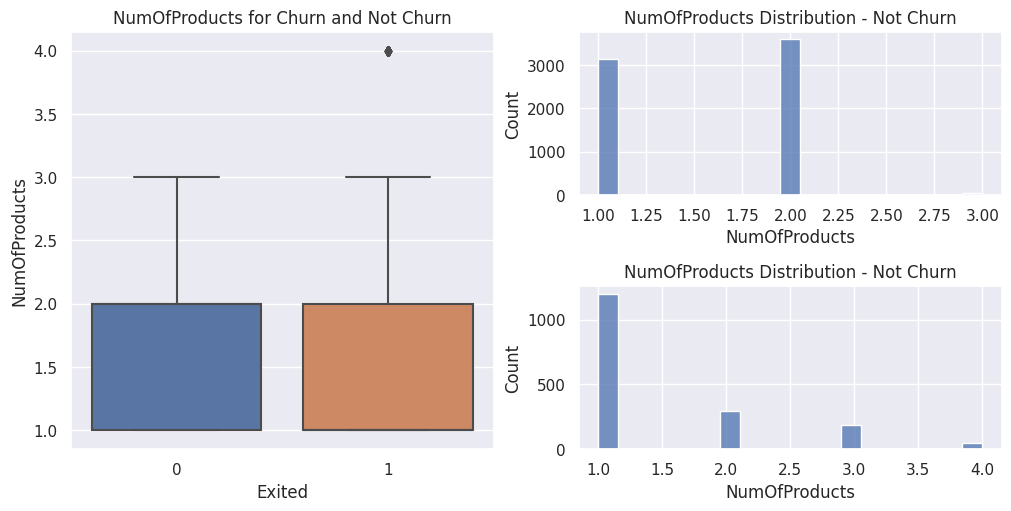

In [173]:
# NumOfProducts
axd = plt.figure(figsize=(10,5), constrained_layout=True).subplot_mosaic("""AB
                                                                            AC""")

axd['A'].set_title('NumOfProducts for Churn and Not Churn')
sns.boxplot(ax=axd['A'], x='Exited', y='NumOfProducts', data=df4);

axd['B'].set_title('NumOfProducts Distribution - Not Churn')
NumOfProducts0 = df4.loc[df4['Exited'] == 0, 'NumOfProducts']
sns.histplot(ax=axd['B'], data=NumOfProducts0);

axd['C'].set_title('NumOfProducts Distribution - Not Churn')
NumOfProducts1 = df4.loc[df4['Exited'] == 1, 'NumOfProducts']
sns.histplot(ax = axd['C'], data=NumOfProducts1);

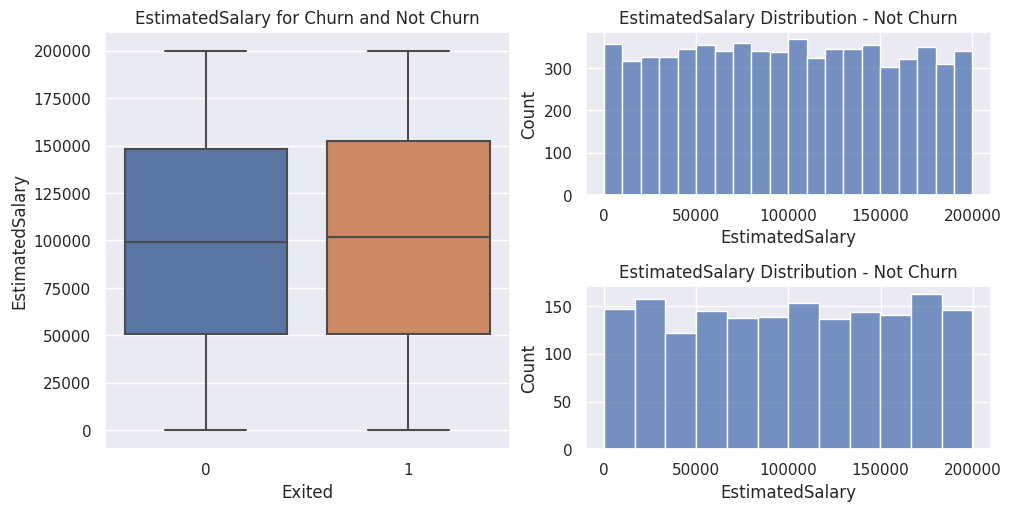

In [174]:
# EstimatedSalary
axd = plt.figure(figsize=(10,5), constrained_layout=True).subplot_mosaic("""AB
                                                                            AC""")

axd['A'].set_title('EstimatedSalary for Churn and Not Churn')
sns.boxplot(ax=axd['A'], x='Exited', y='EstimatedSalary', data=df4);

axd['B'].set_title('EstimatedSalary Distribution - Not Churn')
EstimatedSalary0 = df4.loc[df4['Exited'] == 0, 'EstimatedSalary']
sns.histplot(ax=axd['B'], data=EstimatedSalary0);

axd['C'].set_title('EstimatedSalary Distribution - Not Churn')
EstimatedSalary1 = df4.loc[df4['Exited'] == 1, 'EstimatedSalary']
sns.histplot(ax = axd['C'], data=EstimatedSalary1);

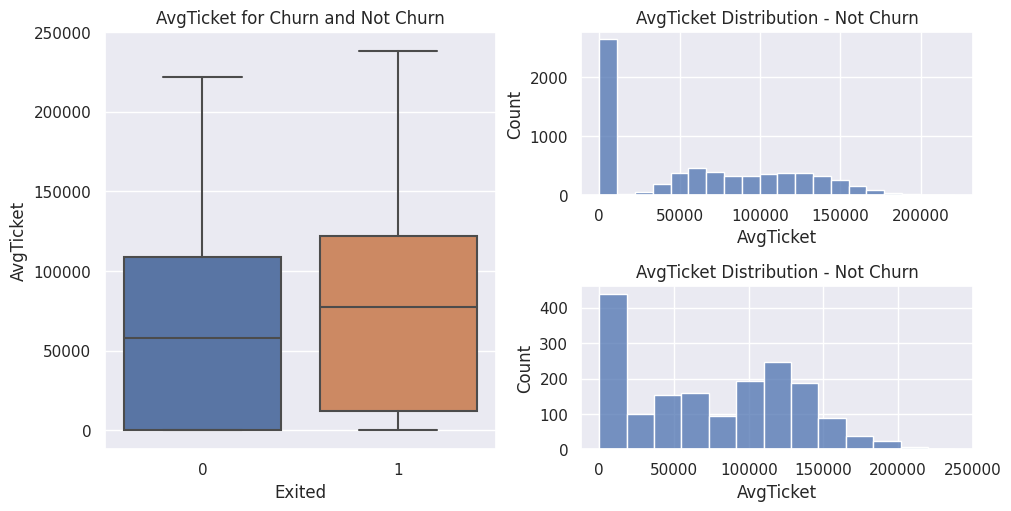

In [175]:
# AvgTicket
axd = plt.figure(figsize=(10,5), constrained_layout=True).subplot_mosaic("""AB
                                                                            AC""")

axd['A'].set_title('AvgTicket for Churn and Not Churn')
sns.boxplot(ax=axd['A'], x='Exited', y='AvgTicket', data=df4);

axd['B'].set_title('AvgTicket Distribution - Not Churn')
AvgTicket0 = df4.loc[df4['Exited'] == 0, 'AvgTicket']
sns.histplot(ax=axd['B'], data=AvgTicket0);

axd['C'].set_title('AvgTicket Distribution - Not Churn')
AvgTicket1 = df4.loc[df4['Exited'] == 1, 'AvgTicket']
sns.histplot(ax = axd['C'], data=AvgTicket1);

### 4.1.3. Categorical Variables

In [176]:
df_churn = df4[df4['Exited'] == 1]
df_nchurn = df4[df4['Exited'] == 0]

/tmp/ipykernel_40995/3948562415.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


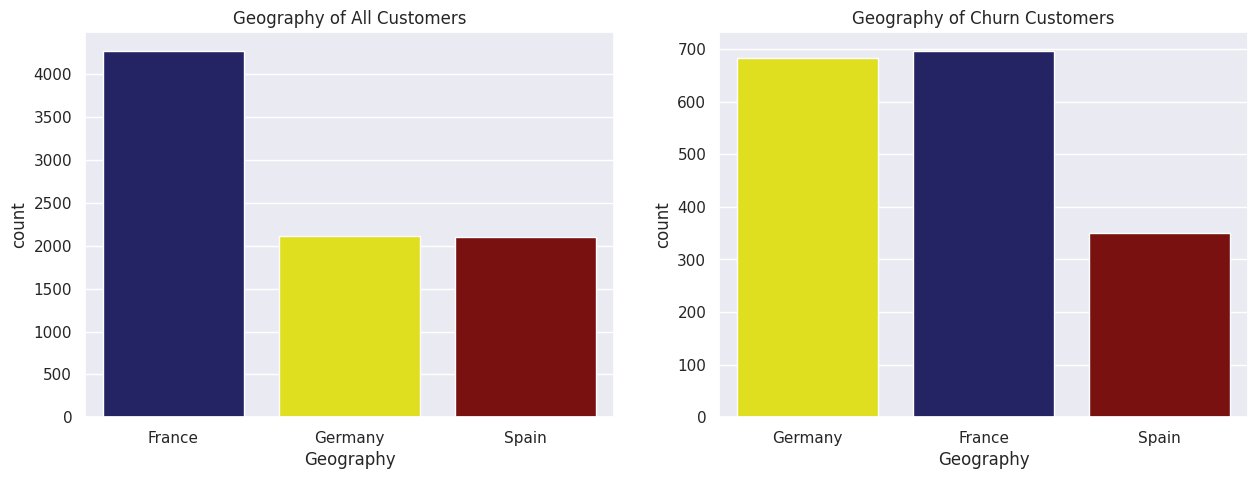

In [177]:
color_dict_geo = {'Spain': '#8B0000',
                  'France': '#191970',
                  'Germany': '#FFFF00'}
# geography
plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)
sns.countplot(x='Geography', data=df4, palette=color_dict_geo);
plt.title('Geography of All Customers');

plt.subplot(1,2,2)
sns.countplot(x='Geography', data=df_churn, palette=color_dict_geo);
plt.title('Geography of Churn Customers');

/tmp/ipykernel_40995/2360163944.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


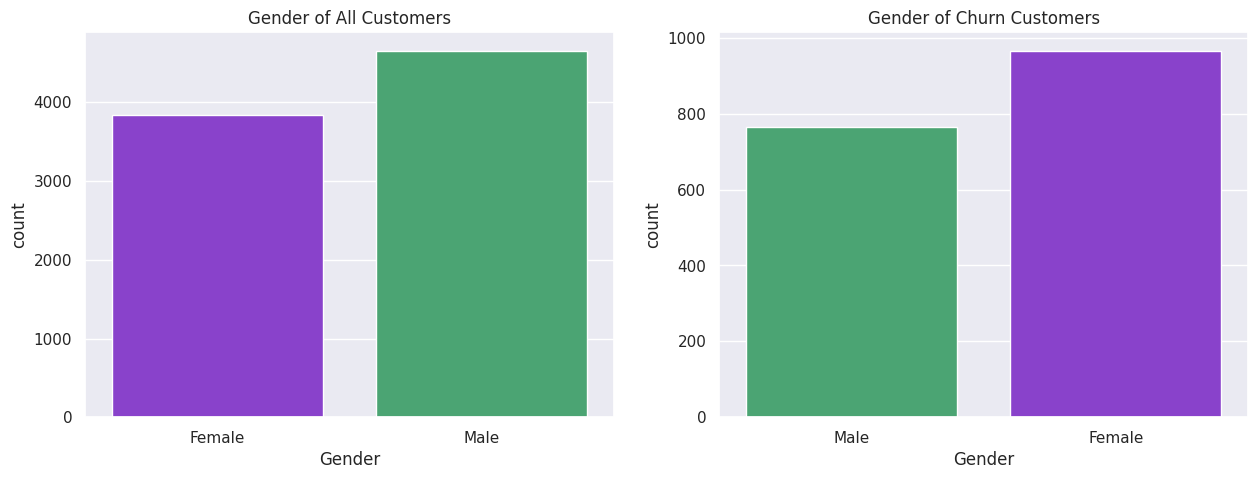

In [178]:
# gender
color_dict_gen = {'Male': '#3CB371',
                  'Female': '#8A2BE2'}

plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)
sns.countplot(x='Gender', data=df4, palette=color_dict_gen);
plt.title('Gender of All Customers');

plt.subplot(1,2,2)
sns.countplot(x='Gender', data=df_churn, palette=color_dict_gen);
plt.title('Gender of Churn Customers');

/tmp/ipykernel_40995/2755154098.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


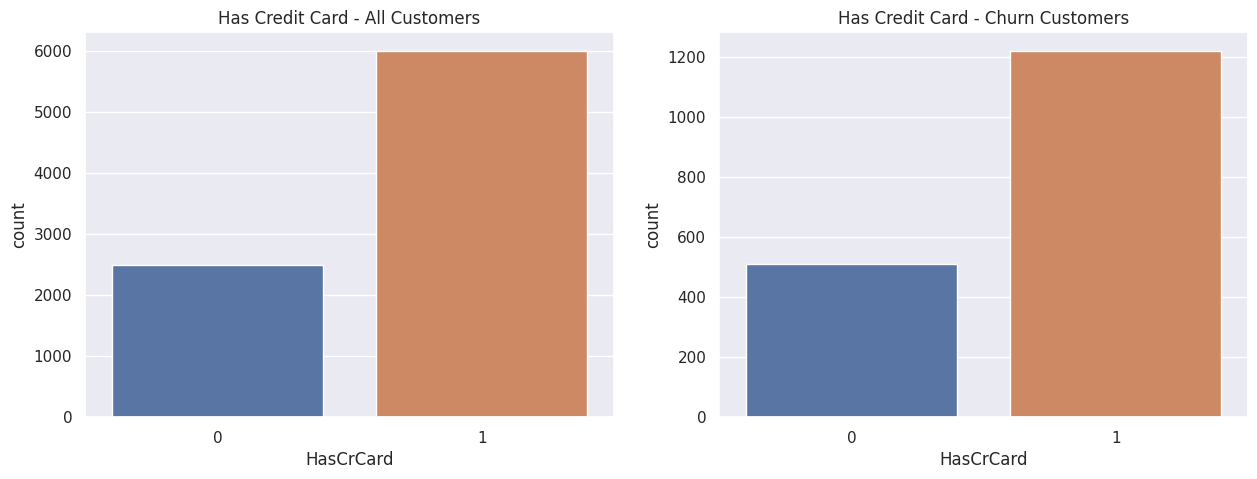

In [179]:
# has credit card
plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)
sns.countplot(x='HasCrCard', data=df4);
plt.title('Has Credit Card - All Customers');

plt.subplot(1,2,2)
sns.countplot(x='HasCrCard', data=df_churn);
plt.title('Has Credit Card - Churn Customers');

/tmp/ipykernel_40995/2048083939.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


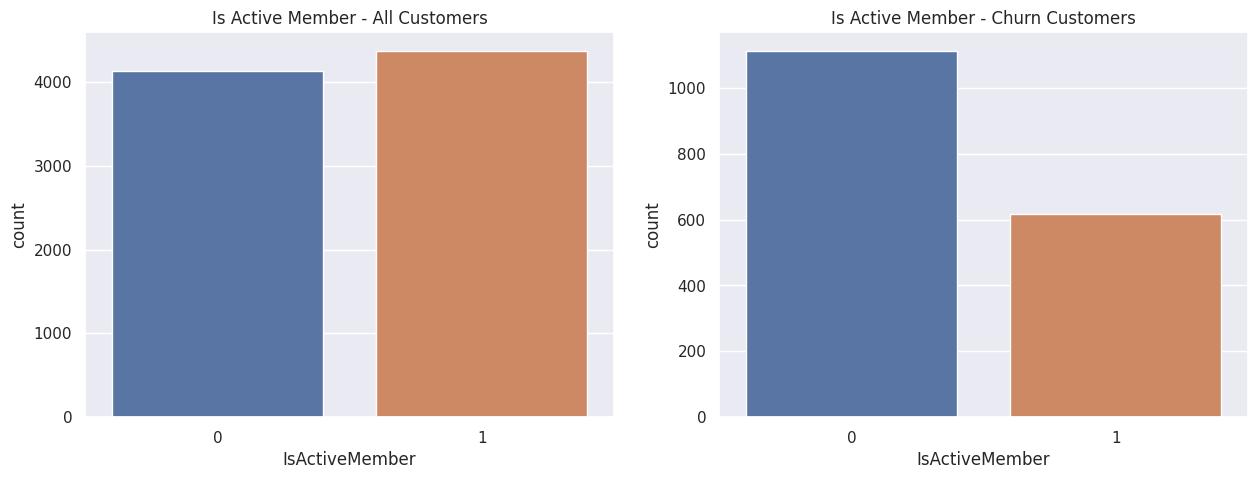

In [180]:
# is active
plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)
sns.countplot(x='IsActiveMember', data=df4);
plt.title('Is Active Member - All Customers');

plt.subplot(1,2,2)
sns.countplot(x='IsActiveMember', data=df_churn);
plt.title('Is Active Member - Churn Customers');

## 4.2. Bivariate Analysis

In [181]:
# create business hypotesis and validate with bivariate analysis

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

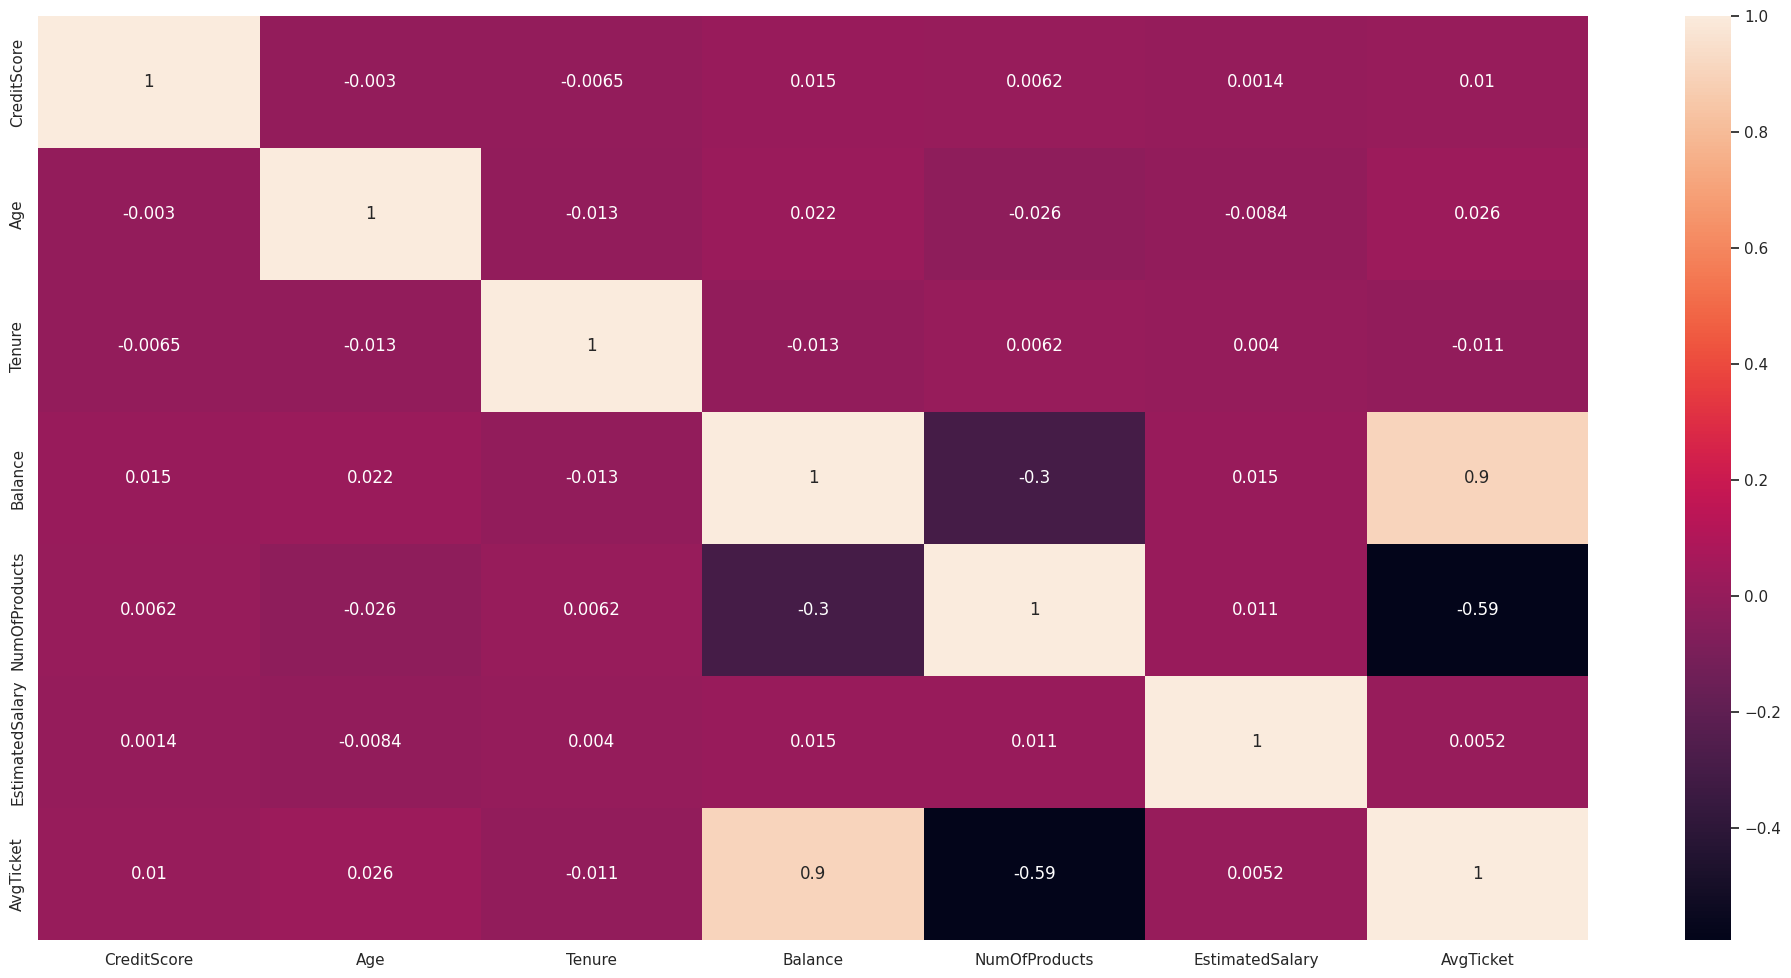

In [182]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Variables

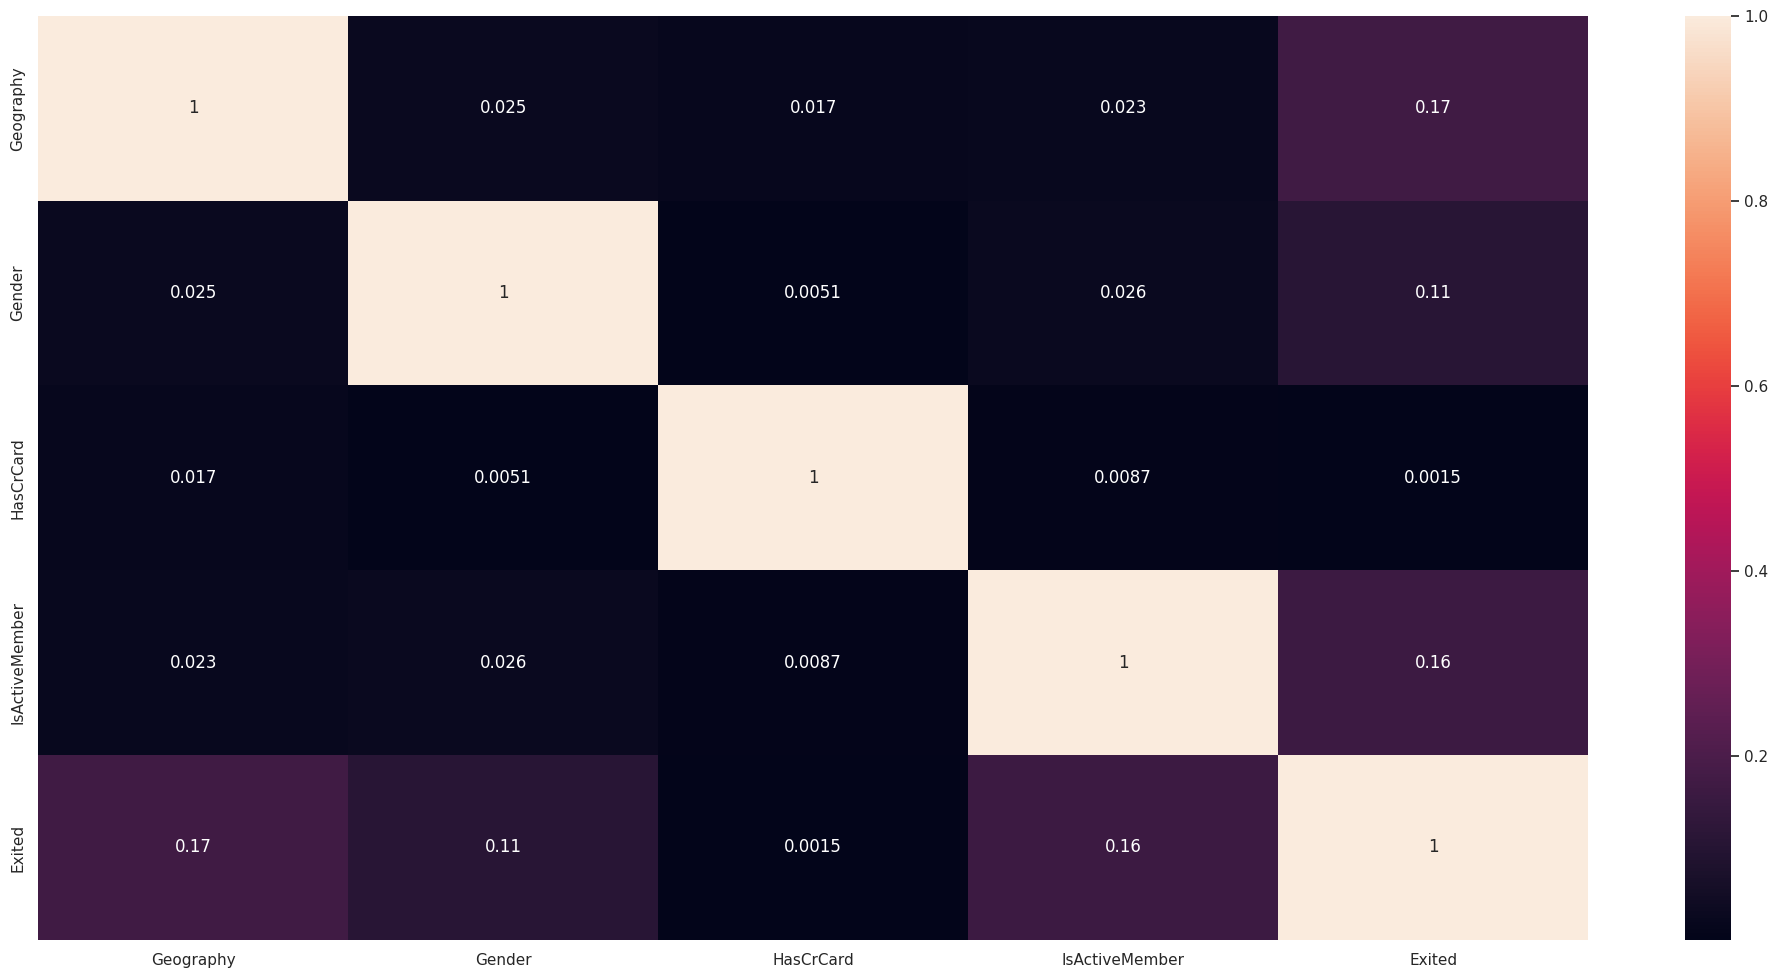

In [183]:
d = pd.DataFrame(corr_cramer_v(cat_attributes))
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# <font color='red'> 5.0. BALANCED DATA - NOT USED</font>

In [184]:
df5 = df4#.copy()

In [185]:
# # geography - One Hot Encoding
# df5 = pd.get_dummies(df5, prefix='Geography', columns=['Geography'], dtype='int64')

# # gender- One Hot Encoding
# df5 = pd.get_dummies(df5, columns=['Gender'], dtype='int64')

In [186]:
# X = df5.drop(['Surname', 'Exited'], axis=1)
# y = df5['Exited']

In [187]:
# # SMOTE + Tomekling
# # define sampler
# smt = cb.SMOTETomek(sampling_strategy='auto', random_state=32)

# # apply sampler
# X_smt, y_smt = smt.fit_resample(X, y)

In [188]:
# df51 = pd.concat([X_smt, y_smt], axis=1)

# 6.0. DATA PREPARATION

In [189]:
#df6 = df51.copy()
df6 = df5#.copy()

# drop customer id
df6.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

## 6.1. Standardization

In [190]:
# looking at session 4.1.2, the only feature that resemble a normal distribution is CredictScore
ss = pp.StandardScaler()

df6['CreditScore'] = ss.fit_transform(df6[['CreditScore']].values)
pickle.dump(ss, open('/home/felipe/repos/churn_indi/src/parameters/CreditScoreScaler.pkl', 'wb'))

## 6.2. Rescaling

In [191]:
# instantiate scalers
mm = pp.MinMaxScaler()
rs = pp.RobustScaler()

In [192]:
# Age
df6['Age'] = rs.fit_transform(df6[['Age']].values)
pickle.dump(rs, open('/home/felipe/repos/churn_indi/src/parameters/AgeScaler.pkl', 'wb'))

# Tenure
df6['Tenure'] = mm.fit_transform(df6[['Tenure']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/TenureScaler.pkl', 'wb'))

# Balance
df6['Balance'] = mm.fit_transform(df6[['Balance']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/BalanceScaler.pkl', 'wb'))

# Number of Products
df6['NumOfProducts'] = mm.fit_transform(df6[['NumOfProducts']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/NumOfProductsScaler.pkl', 'wb'))

# Estimated Salary
df6['EstimatedSalary'] = mm.fit_transform(df6[['EstimatedSalary']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/EstimatedSalaryScaler.pkl', 'wb'))

# Average Ticket
df6['AvgTicket'] = mm.fit_transform(df6[['AvgTicket']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/AvgTicketScaler.pkl', 'wb'))

## 6.3. Encoding

In [193]:
# geography - One Hot Encoding
df6 = pd.get_dummies(df6, prefix='Geography', columns=['Geography'], dtype='int64')

# gender- One Hot Encoding
df6 = pd.get_dummies(df6, columns=['Gender'], dtype='int64')

## 6.4. Train and Validation Split

In [194]:
# split training and validation datasets
X = df6.drop('Exited', axis=1)
y = df6['Exited'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.15)

# 7.0. FEATURE SELECTION

In [195]:
df7 = df6#.copy()

## 7.1. Extra Tree Classifier

In [196]:
# # model definition
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# # data preparation
# x_train_n = df7.drop('Exited', axis=1)
# y_train_n = df7['Exited']
# forest.fit(x_train_n, y_train_n)

In [197]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# # print the feature ranking
# print('Feature Ranking:')
# df = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
#     df = pd.concat([df, aux], axis=0)
    
# print(df.sort_values('importance', ascending=False))

# # plot the impurity-based feature importance of the forest
# plt.figure()
# plt.title('Feature Importances')
# plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()

In [198]:
# cols_selected = [ 'Age', 'Balance', 'HasCrCard', 'NumOfProducts','IsActiveMember', 'Tenure', 'AvgTicket', 'Geography_France',
#                   'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']

# 8.0. MACHINE LEARNING MODELING

## 8.1. Logistic Regression - Baseline

In [199]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict(x_validation)

In [200]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_lr)
recall = mt.recall_score(y_validation, yhat_lr)
f1_score = mt.f1_score(y_validation, yhat_lr, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.58163
Recall: 0.22353
F1 Score: 0.60708


## 8.2. KNN

In [201]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction 
yhat_knn = knn_model.predict(x_validation)

In [202]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_knn)
recall = mt.recall_score(y_validation, yhat_knn)
f1_score = mt.f1_score(y_validation, yhat_knn, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.56757
Recall: 0.24706
F1 Score: 0.61719


## 8.3. Gradient Boosting

In [203]:
## model definition
gdr_model = en.GradientBoostingClassifier(n_estimators=100, random_state=42)

# model training
gdr_model.fit(x_train, y_train)

# model prediction
yhat_gdr = gdr_model.predict(x_validation)

In [204]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_gdr)
recall = mt.recall_score(y_validation, yhat_gdr)
f1_score = mt.f1_score(y_validation, yhat_gdr, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.74150
Recall: 0.42745
F1 Score: 0.72831


## 8.4. Random Forest

In [205]:
# model definition
rf_model = en.RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=None)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict(x_validation)

In [206]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_rf)
recall = mt.recall_score(y_validation, yhat_rf)
f1_score = mt.f1_score(y_validation, yhat_rf, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.75641
Recall: 0.46275
F1 Score: 0.74620


## 8.5. XGBoost

In [207]:
# model definition
xgb_model = XGBClassifier(max_delta_step=8, scale_pos_weight=0.8)

# model training
xgb_model.fit(x_train,y_train.values.ravel())

# model prediction
yhat_xgb = xgb_model.predict(x_validation)

In [208]:
# calculate metrics
precision = mt.precision_score(y_validation, yhat_xgb)
recall = mt.recall_score(y_validation, yhat_xgb)
f1_score = mt.f1_score(y_validation, yhat_xgb, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.71006
Recall: 0.47059
F1 Score: 0.73975


# 9.0. CROSS VALIDATION

In [209]:
# prepare cross validation data
x_train_cv = pd.concat([x_train, x_validation])
y_train_cv = pd.concat([y_train, y_validation])

In [210]:
models_performance_cv = pd.DataFrame({'Model':[], "Precision": [], "Recall": [], "F1_Score": []})
models_performance_cv = cross_validation(models_performance_cv, 5 , 'logistic_regression', lr_model , x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'knn'                , knn_model, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'gradient_boosting'  , gdr_model, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'random_forest'      , rf_model , x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'xgboost_cv'         , xgb_model, x_train_cv, y_train_cv)

/tmp/ipykernel_40995/792578930.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)
/tmp/ipykernel_40995/792578930.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)
/tmp/ipykernel_40995/792578930.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignor

In [211]:
models_performance_cv

,Model,Precision,Recall,F1_Score
0,logistic_regression,0.6055 +/- 0.0432,0.2046 +/- 0.0118,0.5981 +/- 0.0099
1,knn,0.6149 +/- 0.0195,0.2803 +/- 0.0117,0.639 +/- 0.0074
2,gradient_boosting,0.7623 +/- 0.035,0.4595 +/- 0.0278,0.745 +/- 0.0176
3,random_forest,0.749 +/- 0.0236,0.4572 +/- 0.0228,0.7415 +/- 0.0133
4,xgboost_cv,0.7111 +/- 0.034,0.4618 +/- 0.0275,0.7356 +/- 0.0182


# 10.0. HYPERPARAMETER FINE TUNING

In [212]:
# # random parameters ranges
# param = {
#     'n_estimators': [1500, 1700, 2500],
#     'max_depth': [3, 5, 9],
#     'min_samples_split': [2, 5, 7],
#     'class_weight': [None, 'balanced', 'balanced_subsample']
# }

# rf_model = en.RandomForestClassifier()
# rf_grid = ms.GridSearchCV(estimator = rf_model, param_grid = param, cv=3, verbose=2)

# rf_grid.fit(x_train, y_train)

In [213]:
# rf_grid.best_params_

# 11.0. MODEL PERFORMANCE

## 11.1. Retrain Model With All Data

In [214]:
# concat training and validation datasets
x_retrain = pd.concat([x_train, x_validation])
y_retrain = pd.concat([y_train, y_validation])

In [215]:
# model definition
def_model = en.RandomForestClassifier(n_estimators=1500, class_weight='balanced', max_depth=9, min_samples_split=7)

# model training
def_model.fit(x_retrain, y_retrain)

pickle.dump(def_model, open('/home/felipe/repos/churn_indi/src/model/def_model.pkl', 'wb'))

## 11.2. Test Dataset Preparation

In [216]:
# split response variable
x_test = df_test.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis = 1)
y_test = df_test['Exited']

In [217]:
# create new feature
x_test['AvgTicket'] = [np.round(x['Balance'] / x['NumOfProducts'], 2) if x['NumOfProducts'] != 0 else 0 for _, x in x_test.iterrows()]

In [218]:
# loade pickle scalers
CreditScoreScaler     = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/CreditScoreScaler.pkl', 'rb'))
AgeScaler             = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/AgeScaler.pkl', 'rb'))
TenureScaler          = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/TenureScaler.pkl', 'rb'))
BalanceScaler         = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/BalanceScaler.pkl', 'rb'))
NumOfProductsScaler   = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/NumOfProductsScaler.pkl', 'rb'))
EstimatedSalaryScaler = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/EstimatedSalaryScaler.pkl', 'rb'))
AvgTicketScaler       = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/AvgTicketScaler.pkl', 'rb'))

In [219]:
# standardization
# CreditScore
x_test['CreditScore'] = CreditScoreScaler.transform(x_test[['CreditScore']].values)

# Age
x_test['Age'] = AgeScaler.transform(x_test[['Age']].values)

# Tenure
x_test['Tenure'] = TenureScaler.transform(x_test[['Tenure']].values)

# Balance
x_test['Balance'] = BalanceScaler.transform(x_test[['Balance']].values)

# NumOfProducts
x_test['NumOfProducts'] = NumOfProductsScaler.transform(x_test[['NumOfProducts']].values)

# EstimatedSalary
x_test['EstimatedSalary'] = EstimatedSalaryScaler.transform(x_test[['EstimatedSalary']].values)

# AvgTicket
x_test['AvgTicket'] = AvgTicketScaler.transform(x_test[['AvgTicket']].values)

# geography - One Hot Encoding
x_test = pd.get_dummies(x_test, prefix='Geography', columns=['Geography'], dtype='int64')

# gender- One Hot Encoding
x_test = pd.get_dummies(x_test, columns=['Gender'], dtype='int64')

## 11.3. Get Performance in Test Dataset

In [220]:
# apply retrained model
pred_test = def_model.predict(x_test)
pred_test_proba = def_model.predict_proba(x_test)

In [221]:
# performance
# calculate metrics
precision = mt.precision_score(y_test, pred_test)
recall = mt.recall_score(y_test, pred_test)
f1_score = mt.f1_score(y_test, pred_test, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.60440
Recall: 0.71661
F1 Score: 0.77828


## 11.4. Plots

### 11.4.1. Confustion Matrix

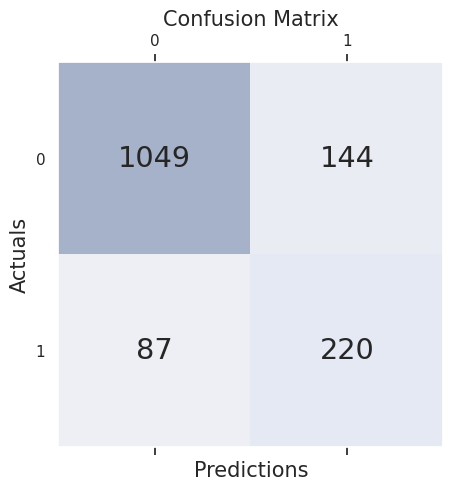

In [222]:
conf_matrix = mt.confusion_matrix(y_test, pred_test)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
ax.grid(False)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

### 11.4.2. Precision x Recall Curve

Text(0.5, 1.0, 'Precision x Recall')

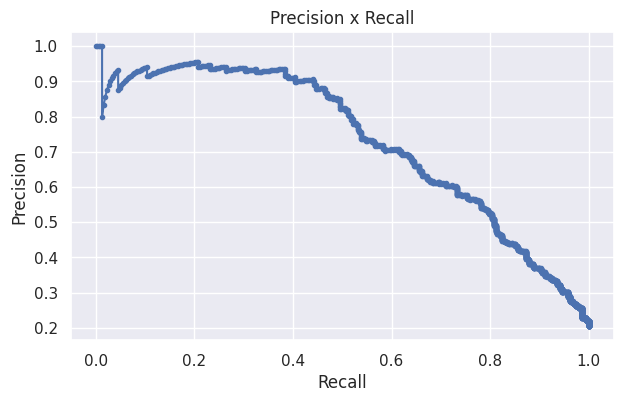

In [223]:
pred_test_aux = pred_test_proba[:,1]

precision, recall, tresholds = mt.precision_recall_curve(y_test, pred_test_aux)

plt.figure(figsize = (7,4))
plt.plot(recall, precision, marker='.', label='Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision x Recall')

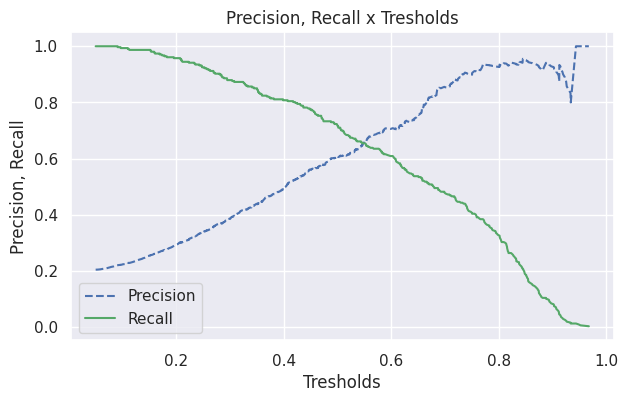

In [224]:
plt.figure(figsize = (7,4))
plt.plot(tresholds, precision[:-1], 'b--', label='Precision')
plt.plot(tresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Tresholds')
plt.ylabel('Precision, Recall')
plt.title('Precision, Recall x Tresholds')
plt.legend()

### 11.4.3. Cumulative Gain and Lift Curves

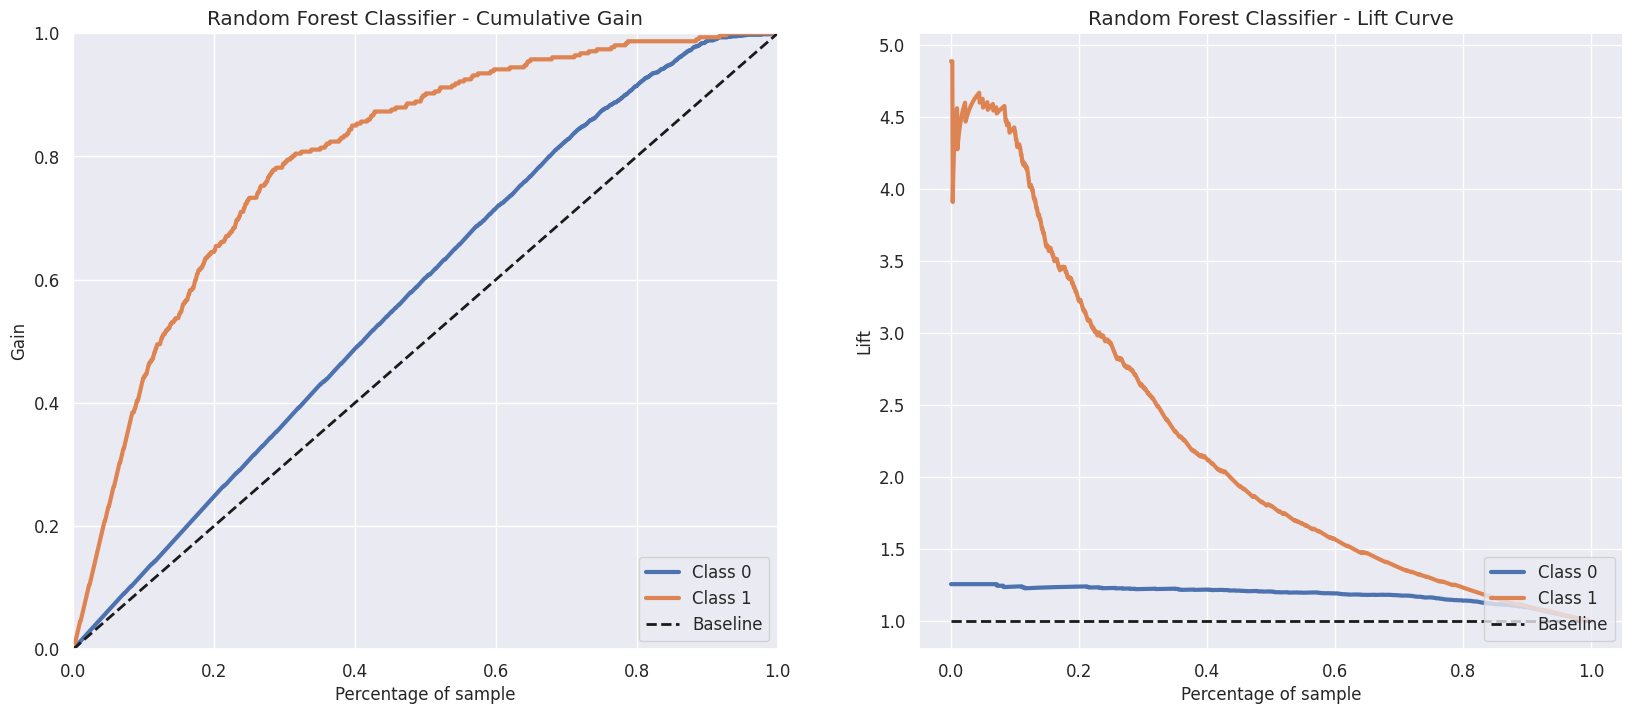

In [225]:
# plots
plt.figure(figsize = (20,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

skplt.metrics.plot_cumulative_gain(y_test, pred_test_proba, figsize=(1, 1), ax=ax1, title='Random Forest Classifier - Cumulative Gain');
skplt.metrics.plot_lift_curve(y_test, pred_test_proba, figsize=(1, 1), ax=ax2, title='Random Forest Classifier - Lift Curve');

# 12.0 API TESTER

In [226]:
# load results dataset
df_api = pd.read_csv('../data/abandono_teste.csv', delimiter=';')

In [227]:
# convert dataframe to json
data = json.dumps(df_api.to_dict(orient='records'))

In [228]:
# API call
url = 'http://0.0.0.0:5000/ChurnInd/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code: {}'.format(r.status_code))

Status Code: 200


In [229]:
# get preditions
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [230]:
# save results file
df_result = pd.concat([df_api['RowNumber'], d1['Exited']], axis=1).reset_index(drop=True)
df_result.to_csv('../data/results.csv', index=False)